In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import  preprocessing
from datetime import datetime
#To plot figs on jupyter
%matplotlib inline
# figure size in inches
sns.set(rc={'figure.figsize':(10, 10)})


# W207 Final Project
Michael Zeng, Param Viswanathan

# Introduction

* Our goal is the analyze the loan data and train a model to identify if the next loan applicant will default or not.
* We will be assigning a risk factor of high, medium and low based on the characteristics of the loan and the loan applicant
* We will divide the data set into 3 parts
    * Training data
    * Dev data
    * Test data
* We will first do EDA on the data to understand it better and then decide on how to clean up the data and also transform any values for certain features
* We will be evaluating various machine learning classifiers
    * Logistic Regression
    * K-means
    * Naive Bayesian
    * K-means Clustering
    * Gaussian Mixture Model

# Loading Data and Visualization

In [6]:
df = pd.read_csv("lending-club-loan-data/loan.csv",low_memory=False)

In [7]:
original_df_loan = df

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [9]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Percentage Committed by Investors')

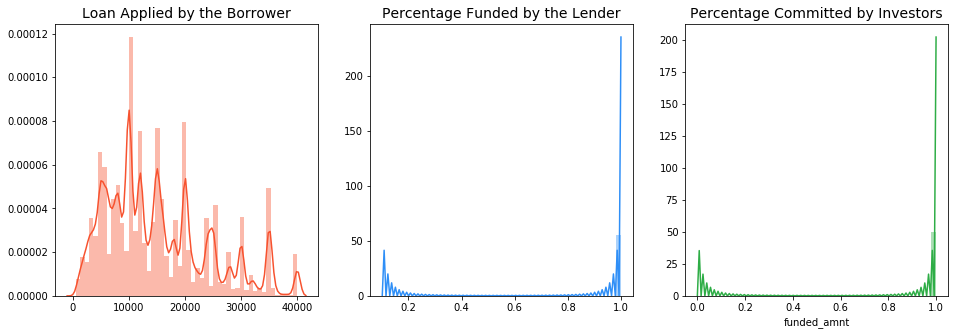

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amnt"].values
funded_amount_pct = df["funded_amnt"].values / loan_amount
investor_funds_pct = df["funded_amnt_inv"].values / df.funded_amnt


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount_pct, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Percentage Funded by the Lender", fontsize=14)
sns.distplot(investor_funds_pct, ax=ax[2], color="#2EAD46")
ax[2].set_title("Percentage Committed by Investors", fontsize=14)

In [7]:
sum(df['loan_amnt'] >= df['funded_amnt']) / df.shape[0]

In [8]:
sum(df['loan_amnt'] >= df['funded_amnt_inv']) / df.shape[0]

In [9]:
sum(df.loan_amnt > df.funded_amnt)

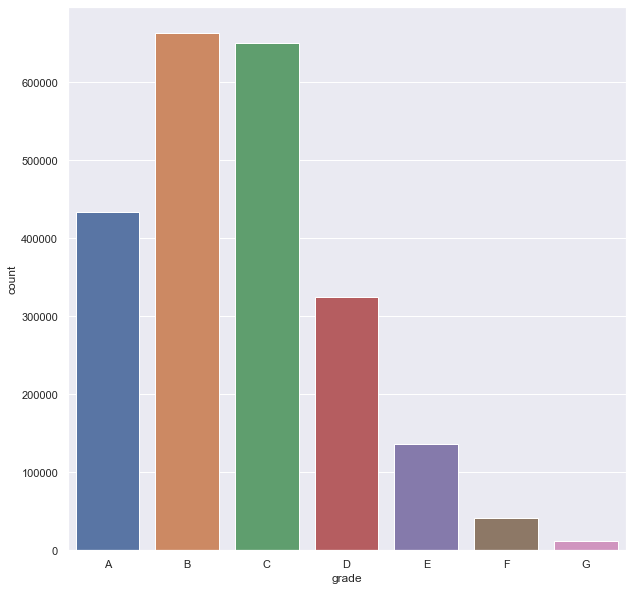

In [23]:
sns.countplot(x = 'grade', data=df, order= ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

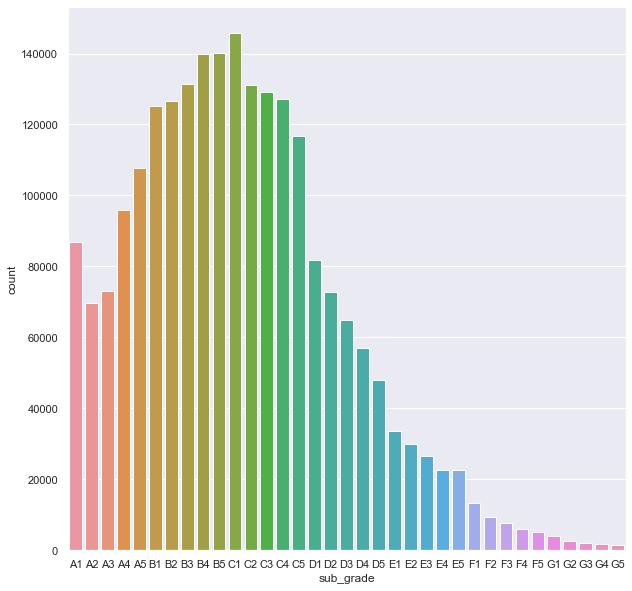

In [24]:
sns.countplot(x = 'sub_grade', data=df, order=np.sort(df.sub_grade.unique()))

In [25]:
len(df.emp_title.unique())

512695

In [26]:
df.emp_length.unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

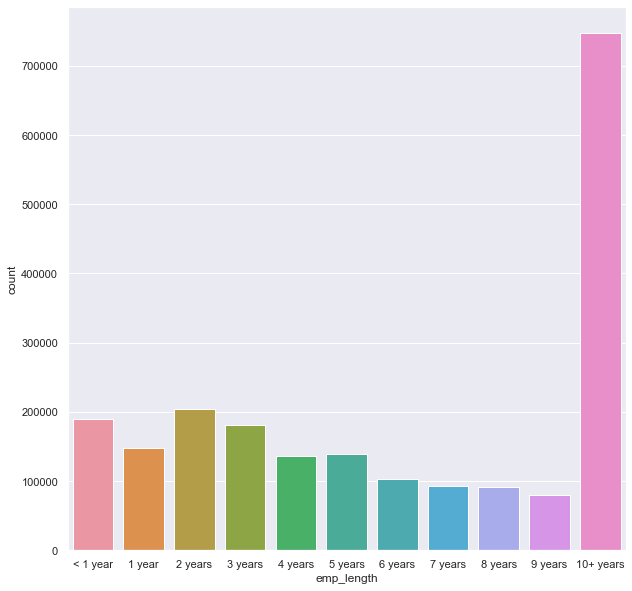

In [28]:
sns.countplot(x = 'emp_length', data=df, 
              order = ['< 1 year', '1 year', '2 years', '3 years',
                      '4 years', '5 years', '6 years', '7 years', 
                      '8 years', '9 years', '10+ years'])

[Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'credit_card'),
 Text(0, 0, 'house'),
 Text(0, 0, 'car'),
 Text(0, 0, 'other'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'renewable_energy'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'wedding'),
 Text(0, 0, 'educational')]

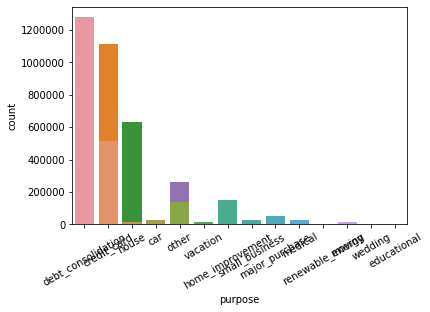

In [16]:
sns.countplot(x = 'home_ownership', data=df)

sns.countplot(x = 'verification_status', data=df)

sns.countplot(x = 'loan_status', data=df)

p = sns.countplot(x = 'loan_status', data=df)
p.set_xticklabels(rotation = 30, labels= df.loan_status.unique())

p = sns.countplot(x = 'purpose', data=df)
p.set_xticklabels(rotation = 30, labels= df.purpose.unique())

# Data Cleaning

The data is updated 4 months ago. For loans issued recently that are still in term (not yet defaulted), we are not sure if they are going to default. So the first thing to do is to remove them so that we are left with a data set with reliable labels.

In [16]:
# the data set is as of 4 months ago
df['loan_age_months'] = df.issue_d.apply(lambda x: (datetime.now() - datetime.strptime(x, '%b-%Y')).days / 30) - 4

# sns.distplot(df.loan_age_months)

df.term.unique()
df['term_months'] = (df.term == ' 36 months') * 36 + (1 - (df.term == ' 36 months')) * 60
sum(df.term_months <= df.loan_age_months) / df.shape[0]

0.36264811993623125

In [17]:
# loans still within loan term
df.loan_status[(df.term_months > df.loan_age_months)].value_counts()

Current               892286
Fully Paid            377195
Charged Off           138476
Late (31-120 days)     20731
In Grace Period         8543
Late (16-30 days)       3583
Default                   27
Name: loan_status, dtype: int64

In [18]:
# loans that are already done
df.loan_status[(df.term_months <= df.loan_age_months)].value_counts()

Fully Paid                                             664757
Charged Off                                            123179
Current                                                 27409
Does not meet the credit policy. Status:Fully Paid       1988
Late (31-120 days)                                       1166
Does not meet the credit policy. Status:Charged Off       761
In Grace Period                                           409
Late (16-30 days)                                         154
Default                                                     4
Name: loan_status, dtype: int64

In [19]:
bad_loan_status = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
                   "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

In [20]:
might_still_default = (df.loan_status == 'Current') & (df.term_months > df.loan_age_months)

In [21]:
df_m = df[~ might_still_default]

## Deal with Categorical Variable
We plan to leave all the numerical features in, while one-hot encode all the categorical ones. 

In [22]:
df_m.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_age_months,term_months
100,NaN,NaN,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.6,36
152,NaN,NaN,40000,40000,40000.0,60 months,16.14,975.71,C,C4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.6,60
170,NaN,NaN,20000,20000,20000.0,36 months,7.56,622.68,A,A3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.6,36
186,NaN,NaN,4500,4500,4500.0,36 months,11.31,147.99,B,B3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.6,36
215,NaN,NaN,8425,8425,8425.0,36 months,27.27,345.18,E,E5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,3.6,36


In [23]:
df_m = df_m.reindex()

In [24]:
df_m.dtypes

id                                            float64
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [25]:
na_pct = df_m.isna().sum() / df_m.shape[0]

In [26]:
# we will simply remove them
df_m = df_m[na_pct[na_pct < 0.5].index]

In [27]:
df_m.shape

(1368382, 89)

In [28]:
na_pct = df_m.isna().sum() / df_m.shape[0]
na_pct.sort_values()

loan_amnt                     0.000000
initial_list_status           0.000000
out_prncp                     0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
revol_bal                     0.000000
total_rec_late_fee            0.000000
collection_recovery_fee       0.000000
last_pymnt_amnt               0.000000
policy_code                   0.000000
loan_age_months               0.000000
hardship_flag                 0.000000
disbursement_method           0.000000
debt_settlement_flag          0.000000
recoveries                    0.000000
addr_state                    0.000000
application_type              0.000000
term_months                   0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
pymnt_plan                    0.000000
purpose                  

In [29]:
# now we will have to deal with categorical variables
df_m.dtypes.sort_values().unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [30]:
df_m.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal   

In [31]:
df_m.dtypes[df_m.dtypes == 'int64'].index

Index(['loan_amnt', 'funded_amnt', 'revol_bal', 'policy_code', 'term_months'], dtype='object')

In [32]:
int_cols = list(df_m.dtypes[df_m.dtypes == 'int64'].index)
int_cols

['loan_amnt', 'funded_amnt', 'revol_bal', 'policy_code', 'term_months']

In [33]:
flt_cols = list(df_m.dtypes[df_m.dtypes == 'float64'].index)
flt_cols

['funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'p

In [34]:
cat_cols = list(df_m.select_dtypes(include=['O']))
cat_cols

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [35]:
# term
print(df_m.term.value_counts())
df_m['term_cat'] = (df_m.term == ' 36 months') * 1
df_m.term_cat.value_counts()

 36 months    1036761
 60 months     331621
Name: term, dtype: int64


1    1036761
0     331621
Name: term_cat, dtype: int64

In [36]:
# grade
print(df_m.grade.value_counts())

for grade_i in df_m.grade.unique():
    df_m['grade_' + grade_i + '_cat'] = (df_m.grade == grade_i) * 1
df_m.drop(columns= 'grade_G_cat', inplace=True)

B    396578
C    389515
A    236463
D    206623
E     96528
F     33078
G      9597
Name: grade, dtype: int64


In [37]:
# home_ownership
print(df_m.home_ownership.value_counts())

for home_ownership in ['MORTGAGE', 'RENT', 'OWN']:
    df_m['home_ownership_' + home_ownership + '_cat'] = (df_m.home_ownership == home_ownership) * 1

MORTGAGE    674882
RENT        545124
OWN         147851
ANY            290
OTHER          182
NONE            53
Name: home_ownership, dtype: int64


In [38]:
# verification_status
for verification_status_i in ['Source Verified', 'Verified']:
    df_m['verification_status_' + verification_status_i.replace(" ", "") + '_cat'] = (df_m.verification_status == verification_status_i) * 1

In [39]:
# emp_length 
def extract_emp_length(x):
    if str(x).split()[0] == 'nan':
        return(0)
    elif str(x).split()[0] == '<':
        return(1)
    elif str(x).split()[0] == '10+':
        return(10)
    else:
        return(int(str(x).split()[0]))
df_m['emp_length_num'] = df_m['emp_length'].apply(lambda x: extract_emp_length(x))

In [40]:
df_m['emp_length_num'].value_counts().sort_values()

9      51680
7      60350
8      61677
6      63797
0      80775
4      81893
5      85536
3     109452
2     123615
1     200219
10    449388
Name: emp_length_num, dtype: int64

In [41]:
# loan_status
df_m['default'] = df_m.loan_status.apply(lambda x: (x in bad_loan_status) * 1)
df_m['default'].value_counts()

0    1071349
1     297033
Name: default, dtype: int64

In [42]:
# purpose
for purpose_i in df_m.purpose.unique():
    df_m['purpose_' + purpose_i + '_cat'] = (df_m.purpose == purpose_i) * 1

df_m.drop(columns= 'purpose_educational_cat', inplace=True)

In [43]:
# hardship
df_m['hardship_flag_cat'] = (df_m.hardship_flag == 'Y') * 1
df_m.hardship_flag_cat.value_counts()

0    1367507
1        875
Name: hardship_flag_cat, dtype: int64

In [44]:
df_m['debt_settlement_flag_cat'] = (df_m.debt_settlement_flag == 'Y') * 1
df_m.debt_settlement_flag_cat.value_counts()

0    1335351
1      33031
Name: debt_settlement_flag_cat, dtype: int64

In [45]:
numeric_cols = list(df_m.dtypes[df_m.dtypes == 'int64'].index) + list(df_m.dtypes[df_m.dtypes == 'float64'].index)

In [46]:
df_m_n = df_m[numeric_cols]

In [47]:
df_m_n.describe()

,loan_amnt,funded_amnt,revol_bal,policy_code,term_months,term_cat,grade_D_cat,grade_C_cat,grade_A_cat,grade_B_cat,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_age_months
count,1.368382e+06,1.368382e+06,1.368382e+06,1368382.0,1.368382e+06,1.368382e+06,1.368382e+06,1.368382e+06,1.368382e+06,1.368382e+06,...,1.298106e+06,1.297952e+06,1.303812e+06,1.367017e+06,1.368277e+06,1.298106e+06,1.318352e+06,1.318352e+06,1.298106e+06,1.368382e+06
mean,1.446120e+04,1.445252e+04,1.628204e+04,1.0,4.181629e+01,7.576547e-01,1.509980e-01,2.846537e-01,1.728048e-01,2.898153e-01,...,2.179481e+00,9.412432e+01,4.528386e+01,1.342090e-01,5.273274e-02,1.739489e+05,4.970207e+04,2.157018e+04,4.215974e+04,4.601560e+01
std,8.736053e+03,8.732283e+03,2.247972e+04,0.0,1.028405e+01,4.285023e-01,3.580471e-01,4.512495e-01,3.780786e-01,4.536767e-01,...,1.846579e+00,8.787615e+00,3.601973e+01,3.778011e-01,4.033008e-01,1.779128e+05,4.780406e+04,2.151396e+04,4.332660e+04,1.993007e+01
min,5.000000e+02,5.000000e+02,0.000000e+00,1.0,3.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.600000e+00
25%,8.000000e+03,8.000000e+03,5.942000e+03,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,9.130000e+01,1.110000e+01,0.000000e+00,0.000000e+00,4.946700e+04,2.088300e+04,7.700000e+03,1.471300e+04,3.303333e+01
50%,1.200000e+04,1.200000e+04,1.113800e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,9.790000e+01,4.290000e+01,0.000000e+00,0.000000e+00,1.117000e+05,3.730700e+04,1.500000e+04,3.168200e+04,4.420000e+01
75%,2.000000e+04,2.000000e+04,1.977100e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,3.000000e+00,1.000000e+02,7.500000e+01,0.000000e+00,0.000000e+00,2.514318e+05,6.257300e+04,2.800000e+04,5.666600e+04,5.740000e+01
max,4.000000e+04,4.000000e+04,2.904836e+06,1.0,6.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.105500e+06,2.101913e+06,1.436333e+02


In [48]:
na_pct = df_m_n.isna().sum() / df_m.shape[0]
na_pct.sort_values()

loan_amnt                       0.000000
purpose_small_business_cat      0.000000
purpose_vacation_cat            0.000000
purpose_medical_cat             0.000000
purpose_major_purchase_cat      0.000000
purpose_renewable_energy_cat    0.000000
purpose_wedding_cat             0.000000
hardship_flag_cat               0.000000
debt_settlement_flag_cat        0.000000
funded_amnt_inv                 0.000000
purpose_moving_cat              0.000000
int_rate                        0.000000
out_prncp                       0.000000
out_prncp_inv                   0.000000
total_pymnt_inv                 0.000000
total_rec_prncp                 0.000000
total_rec_int                   0.000000
total_rec_late_fee              0.000000
recoveries                      0.000000
collection_recovery_fee         0.000000
last_pymnt_amnt                 0.000000
installment                     0.000000
purpose_home_improvement_cat    0.000000
total_pymnt                     0.000000
purpose_house_ca

In [49]:
na_pct[na_pct >0]

annual_inc                    0.000003
dti                           0.000265
delinq_2yrs                   0.000021
inq_last_6mths                0.000022
open_acc                      0.000021
pub_rec                       0.000021
revol_util                    0.000664
total_acc                     0.000021
collections_12_mths_ex_med    0.000106
acc_now_delinq                0.000021
tot_coll_amt                  0.051357
tot_cur_bal                   0.051357
total_rev_hi_lim              0.051357
acc_open_past_24mths          0.036561
avg_cur_bal                   0.051374
bc_open_to_buy                0.046885
bc_util                       0.047455
chargeoff_within_12_mths      0.000106
delinq_amnt                   0.000021
mo_sin_old_il_acct            0.079869
mo_sin_old_rev_tl_op          0.051358
mo_sin_rcnt_rev_tl_op         0.051358
mo_sin_rcnt_tl                0.051357
mort_acc                      0.036561
mths_since_recent_bc          0.046201
mths_since_recent_inq    

In [50]:
X = df_m_n.drop('default', axis=1)
y = df_m_n['default']

In [51]:
X[X.isna()]= 0

In [52]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'revol_bal', 'policy_code', 'term_months',
       'term_cat', 'grade_D_cat', 'grade_C_cat', 'grade_A_cat', 'grade_B_cat',
       'grade_E_cat', 'grade_F_cat', 'home_ownership_MORTGAGE_cat',
       'home_ownership_RENT_cat', 'home_ownership_OWN_cat',
       'verification_status_SourceVerified_cat',
       'verification_status_Verified_cat', 'emp_length_num',
       'purpose_debt_consolidation_cat', 'purpose_credit_card_cat',
       'purpose_other_cat', 'purpose_house_cat', 'purpose_car_cat',
       'purpose_home_improvement_cat', 'purpose_moving_cat',
       'purpose_small_business_cat', 'purpose_vacation_cat',
       'purpose_medical_cat', 'purpose_major_purchase_cat',
       'purpose_renewable_energy_cat', 'purpose_wedding_cat',
       'hardship_flag_cat', 'debt_settlement_flag_cat', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
     

# Logistic Regression
Use logistic regression as our base model. 

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 101)

In [54]:
X_train.describe()

,loan_amnt,funded_amnt,revol_bal,policy_code,term_months,term_cat,grade_D_cat,grade_C_cat,grade_A_cat,grade_B_cat,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_age_months
count,1.094705e+06,1.094705e+06,1.094705e+06,1094705.0,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,...,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06,1.094705e+06
mean,1.446560e+04,1.445687e+04,1.628842e+04,1.0,4.181454e+01,7.577274e-01,1.508425e-01,2.845013e-01,1.731023e-01,2.899201e-01,...,2.067029e+00,8.927645e+01,4.312227e+01,1.341174e-01,5.253836e-02,1.649993e+05,4.790360e+04,2.079020e+04,4.000606e+04,4.600842e+01
std,8.738246e+03,8.734442e+03,2.264873e+04,0.0,1.028301e+01,4.284586e-01,3.578954e-01,4.511768e-01,3.783359e-01,4.537253e-01,...,1.861273e+00,2.249614e+01,3.644202e+01,3.780294e-01,4.018270e-01,1.778560e+05,4.796355e+04,2.154413e+04,4.326413e+04,1.992938e+01
min,5.000000e+02,5.000000e+02,0.000000e+00,1.0,3.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.600000e+00
25%,8.000000e+03,8.000000e+03,5.945000e+03,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,8.970000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.340000e+04,1.909600e+04,7.000000e+03,1.140100e+04,3.303333e+01
50%,1.200000e+04,1.200000e+04,1.114400e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,9.700000e+01,4.000000e+01,0.000000e+00,0.000000e+00,1.007900e+05,3.592300e+04,1.440000e+04,2.975300e+04,4.420000e+01
75%,2.000000e+04,2.000000e+04,1.977300e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,3.000000e+00,1.000000e+02,7.500000e+01,0.000000e+00,0.000000e+00,2.424590e+05,6.121200e+04,2.730000e+04,5.481100e+04,5.740000e+01
max,4.000000e+04,4.000000e+04,2.904836e+06,1.0,6.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.105500e+06,2.101913e+06,1.436333e+02


In [81]:
scaler = preprocessing.Normalizer()

X_train_scaled = scaler.fit_transform(X_train)

In [82]:
X_train_scaled.shape

(1094705, 95)

In [83]:
n_obs = 10000
lr_clf = LogisticRegression(random_state=0, 
                            max_iter = 1000, 
                            penalty = 'l1', 
                            C = .5)
lr_clf.fit(X_train_scaled[0:n_obs,], y_train[0:n_obs])
predict = lr_clf.predict(X_train_scaled[0:n_obs,])
accuracy = metrics.accuracy_score(y_pred= predict, 
                                  y_true = y_train[0:n_obs])
accuracy

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9765

In [84]:
metrics.f1_score(y_pred= predict, y_true = y_train[0:n_obs])

0.9423312883435583

# Neural Network

In [75]:
import keras 
import tensorflow as tf
import keras.backend as K


In [85]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


In [86]:
model = keras.Sequential()
model.add(keras.layers.Dense(12, input_dim=X_train_scaled.shape[1], 
                activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss=f1_loss, 
              optimizer='adam', 
              metrics=['accuracy', f1])
hist = model.fit(X_train_scaled, y_train, epochs=5, batch_size=10,
          validation_split = .2)


Train on 875764 samples, validate on 218941 samples
Epoch 1/5
875764/875764 [==============================] - 178s 203us/step - loss: 0.1229 - acc: 0.9857 - f1: 0.8828 - val_loss: 0.1091 - val_acc: 0.9926 - val_f1: 0.8902
Epoch 2/5
875764/875764 [==============================] - 184s 210us/step - loss: 0.1020 - acc: 0.9944 - f1: 0.8988 - val_loss: 0.0976 - val_acc: 0.9967 - val_f1: 0.9031
Epoch 3/5
875764/875764 [==============================] - 196s 223us/step - loss: 0.1015 - acc: 0.9944 - f1: 0.8989 - val_loss: 0.0999 - val_acc: 0.9959 - val_f1: 0.8999
Epoch 4/5
875764/875764 [==============================] - 193s 220us/step - loss: 0.1015 - acc: 0.9942 - f1: 0.8986 - val_loss: 0.1022 - val_acc: 0.9951 - val_f1: 0.8976
Epoch 5/5
875764/875764 [==============================] - 200s 228us/step - loss: 0.1014 - acc: 0.9943 - f1: 0.8987 - val_loss: 0.0980 - val_acc: 0.9964 - val_f1: 0.9019


In [90]:
np.unique(predict)

array([0.0000000e+00, 9.0610042e-14, 2.9802322e-08, ..., 9.9999988e-01,
       9.9999994e-01, 1.0000000e+00], dtype=float32)

In [92]:
X_test_scaled = scaler.transform(X_test)
predict = model.predict(X_test_scaled)
predict = (predict > .5)
accuracy = metrics.accuracy_score(y_pred = predict, 
                                  y_true = y_test)
print(accuracy)
f1 = metrics.f1_score(y_pred = predict, 
                            y_true = y_test)
print(f1)

0.9964191364272482
0.9917176566039012
